In [1]:
%reload_ext autoreload

%reset

import numpy as np
from scipy.stats import poisson
from astropy import units

import matplotlib.pyplot as pl
import matplotlib

import healpy as hp

#For making corner plots
from getdist import plots, MCSamples

import pdb

import EPDFABC as epdfabc
import subhalos as subs


matplotlib.rcParams['text.usetex'] = True
matplotlib.rcParams['text.latex.unicode'] = True

%matplotlib inline

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


ERROR:root:Invalid alias: The name clear can't be aliased because it is another magic command.
ERROR:root:Invalid alias: The name more can't be aliased because it is another magic command.
ERROR:root:Invalid alias: The name less can't be aliased because it is another magic command.
ERROR:root:Invalid alias: The name man can't be aliased because it is another magic command.
/home/ebaxter/anaconda2/envs/mypython3/lib/python3.7/site-packages/ipykernel_launcher.py:24: MatplotlibDeprecationWarning: 
The text.latex.unicode rcparam was deprecated in Matplotlib 3.0 and will be removed in 3.2.


#notes:
-assume dark matter signal is isotropic (i.e. compute P(C) at single psi)
-get dark matter spectrum
-implement background drawing
-run ABC


## Example: analyzing the photon count distribution from dark matter annihilation in subhalos

We first compute the PDF of photon counts using the Fourier transform tricks described in e.g. https://arxiv.org/abs/0810.1284v2.

Then, using this PDF, we generate a mock data set assuming some spectrum for the dark matter annihilation.

Finally, we use ABC to analyze this data set to make sure we recover the input parameters.  In this example, we'll consider only one parameter: the normalization of the dark matter signal, which we call PhiPP (PP = short for particle physics).



In [2]:
# Settings for subhalo analysis

physics_settings, obs_settings, fft_settings = subs.get_settings(fft_type = 'fast')

N_E_bins = 5
N_pix = int(4.*np.pi/obs_settings['Omega_pixel'])
N_side = int(np.sqrt(N_pix/12.0))
maxc = 10

print(physics_settings)
print(obs_settings)
print("N_side = ", N_side)

{'R_G': 220, 'd_sun': 8.5, 'M_max': 10000000000.0, 'nside_map': 2048, 'M_min': 1000.0, 'PhiPP': 1.0, 'n': 0, 'beta': 1.9}
{'area': 2000.0, 'obs_time': 10.0, 'fov_factor': 0.2, 'Omega_pixel': 0.0010226538585904274, 'psi': 0.6981317007977318}


In [3]:
# Compute the PDF of photon counts using the Fourier transform trick.  Note that this can be slow.

counts = np.arange(0,20)
pc, f_pf_precomputed, pf_pf_precomputed = subs.get_pc(counts, physics_settings, fft_settings, \
                                                      obs_settings, return_fpf = True)

-0.00018908943438584658


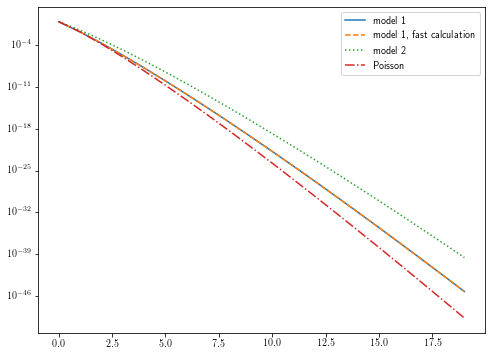

In [4]:
# In order to speed our analysis, we'll using a pre-computed P(F).  Then,changing PhiPP amounts to 
# just rescaling this function, and convolving with a Poisson distribution to get P(C).

#fast P(C) calculation using pre-computed P(F)
default_phipp = 1.0
pc_fast1 = subs.get_pc_fast(counts, f_pf_precomputed, pf_pf_precomputed, physics_settings, obs_settings, default_phipp = default_phipp)
physics_settings2 = physics_settings.copy()
physics_settings2['PhiPP'] = 2.0
pc_fast2 = subs.get_pc_fast(counts, f_pf_precomputed, pf_pf_precomputed, physics_settings2, obs_settings, default_phipp = default_phipp)   
print(np.sum(pc_fast1))

poisson_pc = poisson.pmf(counts, np.sum(pc*counts/np.sum(pc)))

fig, ax = pl.subplots(1,1, figsize = (8,6))
ax.plot(counts, pc/np.sum(pc), label = 'model 1')
ax.plot(counts, pc_fast1/np.sum(pc_fast1), ls = 'dashed', label = 'model 1, fast calculation')
ax.plot(counts, pc_fast2/np.sum(pc_fast2), ls = 'dotted', label = 'model 2')
ax.plot(counts, poisson_pc, ls = 'dashdot', label = 'Poisson')
ax.set_yscale('log')
ax.legend()


si =  0


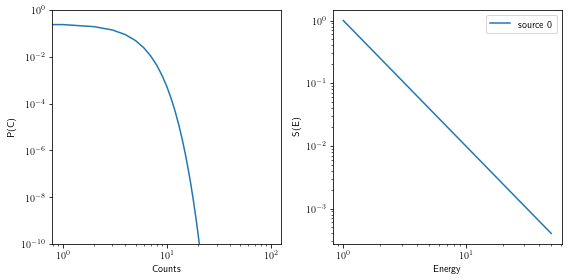

In [9]:
#set up wrappers for pdf functions
def pdf_wrapper(params, counts):
    physics_settings, obs_settings, fft_settings = subs.get_settings(fft_type = 'fast')
    physics_settings['PhiPP'] = params[0]
    pc = subs.get_pc_fast(counts, f_pf_precomputed, pf_pf_precomputed, physics_settings, obs_settings, default_phipp = default_phipp)
    #777777 does this make sense?
    pc = pc/np.sum(pc)
    return pc

def spec_wrapper(params, energy):
    param_dict = {'power_law':params[1]}
    return subs.mock_spectrum(param_dict, energy)

PDF_and_spectra = [[pdf_wrapper, spec_wrapper]]
isotropic = True
energy_range = np.array([1., 50.])
count_range = np.array([0., 100.])
param_names = ['PhiPP', 'alpha']
param_labels = ['\\Phi_{PP}', '\\alpha']
param_min = np.array([0.1, -4.])
param_max = np.array([1000.0, 0.])
param_range = [param_min, param_max]

param_true = np.array([100.0, -2.])

counts = np.arange(0,count_range[1])
energies = np.linspace(energy_range[0], energy_range[1], num = 100)

fig, ax = pl.subplots(1,2, figsize = (8,4))
for si in range(0,len(PDF_and_spectra)):
    print("si = ", si)
    ax[0].plot(counts, PDF_and_spectra[si][0](param_true, counts), label = 'source '+str(si))
    ax[1].plot(energies, PDF_and_spectra[si][1](param_true, energies), label = 'source '+str(si))
ax[0].set_yscale('log')
ax[1].set_xscale('log')
ax[0].set_xscale('log')
ax[1].set_yscale('log')
ax[0].set_xlabel('Counts')
ax[1].set_xlabel('Energy')
ax[0].set_ylabel('P(C)')
ax[1].set_ylabel('S(E)')
ax[1].legend()
ax[0].set_ylim((1.0e-10, 1.0))
fig.tight_layout()

In [10]:
def lnprior(params):
    return 0.

# initialize the EPDFABC object
my_abc = epdfabc.EPDFABC(param_range)

#Setup for binned analysis
my_abc.setup_binned(PDF_and_spectra, isotropic, count_range, energy_range, verbose = False)
my_abc.add_lnprior(lnprior)

In [11]:
#Create mock data with "true" parameters
obs_data = my_abc.generate_mock_data_binned(param_true, N_pix = N_pix, N_energy = N_E_bins, verbose = True)
print(obs_data.shape)

[[[0. 0. 0. 0. 0.]
  [5. 0. 0. 0. 1.]
  [2. 2. 0. 0. 0.]
  ...
  [0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0.]
  [1. 0. 0. 0. 0.]]]
(1, 12288, 5)


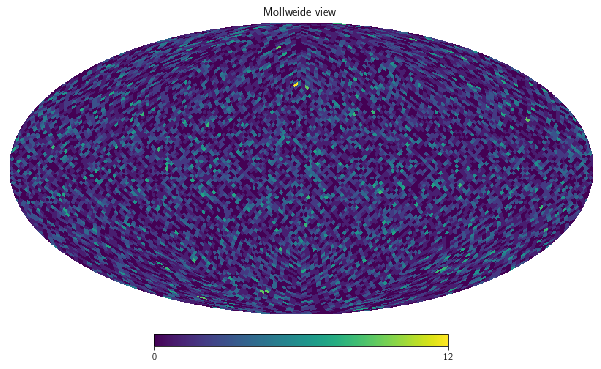

In [12]:
hp.mollview(obs_data[0,:,0])

In [13]:
#Get posterior using ABC
N_samples = 200
posterior_samples = my_abc.run_abc_binned(obs_data, N_samples, epsilon = 100., verbose = True)
print("posterior samples shape = ", posterior_samples.shape)


sample =  0  out of  200
sample =  20  out of  200
sample =  40  out of  200
sample =  60  out of  200
sample =  80  out of  200
sample =  100  out of  200
sample =  120  out of  200
sample =  140  out of  200
sample =  160  out of  200
sample =  180  out of  200
posterior samples shape =  (37, 2)


Removed no burn in


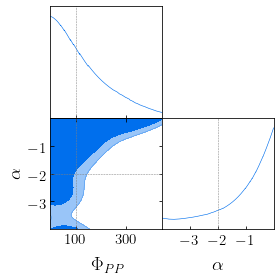

In [14]:
if (1):
    #Getdist requires specification of parameter ranges to get accurate contours
    ranges = {}
    markers={} #true parameter values
    for ii in range(0,len(param_min)):
        ranges[param_names[ii]] = [param_min[ii], param_max[ii]]
        markers[param_names[ii]] = param_true[ii]
        
    psamps = MCSamples(samples = posterior_samples, ranges = ranges, names = param_names, labels = param_labels)    


    g = plots.get_subplot_plotter()
    g.settings.title_limit_fontsize = 16 # reference size for 3.5 inch subplot
    g.settings.axes_fontsize=18
    g.settings.legend_fontsize = 26
    g.settings.axes_labelsize = 22
    g.triangle_plot(psamps, filled=True, markers=markers)

In [1]:
PDF_and_spectra = [[pdf_source1, spectrum_source1], [pdf_source2, spectrum_source2]]
isotropic = True
energy_range = np.array([1., 50.])
count_range = np.array([0., 100.])
param_names = ['barc1', 'barc2', 'a1', 'a2']
param_labels = ['\\bar{C}_1', '\\bar{C}_2', '\\alpha_1', '\\alpha_2']
param_min = np.array([0., 0.5, -2., -2.])
param_max = np.array([40., 1.5, 0., 0.])
param_range = [param_min, param_max]

#properties of summary statistic
N_E_bins = 5
N_pix = 500

param_true = np.array([20., 1.0, -1., -1.5])

counts = np.arange(0,count_range[1])
energies = np.linspace(energy_range[0], energy_range[1], num = 100)

fig, ax = pl.subplots(1,2, figsize = (8,4))
for si in range(0,len(PDF_and_spectra)):
    ax[0].plot(counts, PDF_and_spectra[si][0](param_true, counts), label = 'source '+str(si))
    ax[1].plot(energies, PDF_and_spectra[si][1](param_true, energies), label = 'source '+str(si))
ax[0].set_yscale('log')
ax[1].set_xscale('log')
ax[1].set_yscale('log')
ax[0].set_xlabel('Counts')
ax[1].set_xlabel('Energy')
ax[0].set_ylabel('P(C)')
ax[1].set_ylabel('S(E)')
ax[1].legend()
fig.tight_layout()


NameError: name 'pdf_source1' is not defined

In [4]:
# initialize the EPDFABC object
my_abc = epdfabc.EPDFABC(param_range)

#Setup for binned analysis
my_abc.setup_binned(PDF_and_spectra, isotropic, count_range, energy_range, verbose = True)
my_abc.add_lnprior(lnprior)

N_parameters =  4
Isotropic =  True
parameter min =  [ 0.   0.5 -2.  -2. ]
parameter max =  [40.   1.5  0.   0. ]
Emin =  1.0
Emax =  50.0
N_sources =  2
prior added


In [6]:
#Create mock data with "true" parameters
obs_data = my_abc.generate_mock_data_binned(param_true, N_pix = N_pix, N_energy = N_E_bins, verbose = True)
print(obs_data.shape)

[[[ 6.  3.  0.  0.  3.]
  [19.  6.  2.  0.  1.]
  [ 8.  4.  4.  3.  1.]
  ...
  [15.  2.  3.  3.  1.]
  [ 9.  5.  0.  2.  0.]
  [14.  5.  4.  2.  1.]]]
(1, 500, 5)


In [7]:
#Get posterior using ABC
N_samples = 1000
posterior_samples = my_abc.run_abc_binned(obs_data, N_samples, epsilon = 100., verbose = True)
print("posterior samples shape = ", posterior_samples.shape)


sample =  0  out of  1000
sample =  100  out of  1000
sample =  200  out of  1000
sample =  300  out of  1000
sample =  400  out of  1000
sample =  500  out of  1000
sample =  600  out of  1000
sample =  700  out of  1000
sample =  800  out of  1000
sample =  900  out of  1000
posterior samples shape =  (3, 4)


Removed no burn in


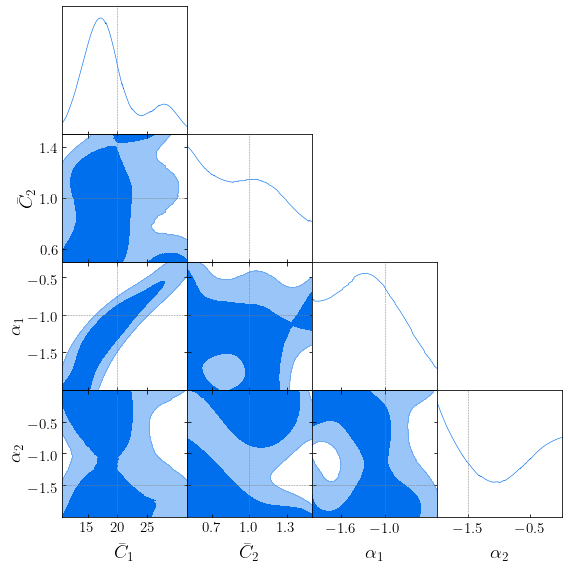

In [5]:
if (1):
    #Getdist requires specification of parameter ranges to get accurate contours
    ranges = {}
    markers={} #true parameter values
    for ii in range(0,len(param_min)):
        ranges[param_names[ii]] = [param_min[ii], param_max[ii]]
        markers[param_names[ii]] = param_true[ii]
        
    psamps = MCSamples(samples = posterior_samples, ranges = ranges, names = param_names, labels = param_labels)    


    g = plots.get_subplot_plotter()
    g.settings.title_limit_fontsize = 16 # reference size for 3.5 inch subplot
    g.settings.axes_fontsize=18
    g.settings.legend_fontsize = 26
    g.settings.axes_labelsize = 22
    g.triangle_plot(psamps, filled=True, markers=markers)

In [6]:
import elfi
from functools import partial

In [7]:
priors = []
for pi in range(0,len(param_min)):
    priors.append(elfi.Prior('uniform', param_min[pi], param_max[pi]-param_min[pi], name = param_names[pi]))

In [8]:
y0 = my_abc.generate_mock_data_binned_ELFI(param_true[0], param_true[1], param_true[2], param_true[3], \
                                           N_pix = N_pix, N_energy = N_E_bins, epdf_object = my_abc)
print(y0.shape)

(1, 100, 5)


In [9]:
fn_simulator = partial(my_abc.generate_mock_data_binned_ELFI, N_pix = N_pix, N_energy = N_E_bins, epdf_object=my_abc)
sim = elfi.Simulator(fn_simulator, *priors, observed=y0)

In [10]:
fn_summary = partial(my_abc.get_summary_from_binned)
S1 = elfi.Summary(fn_summary, sim)

In [11]:
d = elfi.Distance('euclidean', S1)

In [12]:
#rej = elfi.Rejection(d, batch_size=1)
smc = elfi.SMC(d, batch_size=1)


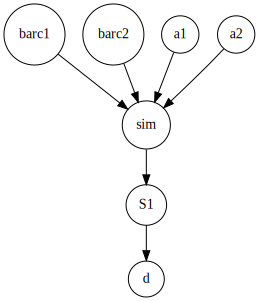

In [13]:
elfi.draw(d)

In [14]:
#res = rej.sample(1000, threshold=20)
N = 1000
schedule = [20., 10., 5.]
res_smc = smc.sample(N, schedule)

ABC-SMC Round 1 / 3
Progress [==================================================] 100.0% Complete
ABC-SMC Round 2 / 3
Progress [==================================================] 100.0% Complete
ABC-SMC Round 3 / 3
Progress [==================================================] 100.0% Complete


In [17]:
elfi_post_samples = np.vstack((res_smc.outputs[param_names[0]], res_smc.outputs[param_names[1]], \
                               res_smc.outputs[param_names[2]], res_smc.outputs[param_names[3]])).transpose()

print(res_smc.summary())
print(elfi_post_samples.shape)

Method: SMC
Number of samples: 1000
Number of simulations: 48210
Threshold: 4.9
Sample means: a1: -1.31, a2: -1.02, barc1: 17.5, barc2: 0.998
None
(1000, 4)


Removed no burn in


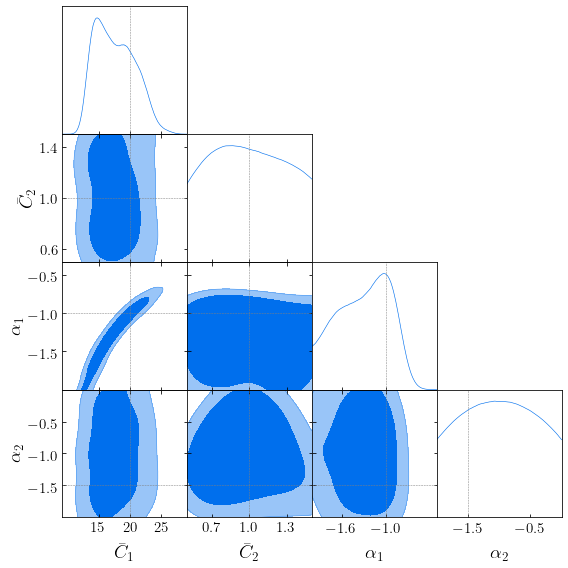

In [21]:
ranges = {}
markers={} #true parameter values
for ii in range(0,len(param_min)):
    ranges[param_names[ii]] = [param_min[ii], param_max[ii]]
    markers[param_names[ii]] = param_true[ii]

    
ELFI_samps = MCSamples(samples = elfi_post_samples, ranges = ranges, names = param_names, labels = param_labels)    



g = plots.get_subplot_plotter()
g.settings.title_limit_fontsize = 16 # reference size for 3.5 inch subplot
g.settings.axes_fontsize=18
g.settings.legend_fontsize = 26
g.settings.axes_labelsize = 22
g.triangle_plot(ELFI_samps, filled=True, markers=markers)

